/tmp/ipykernel_18138/506771030.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


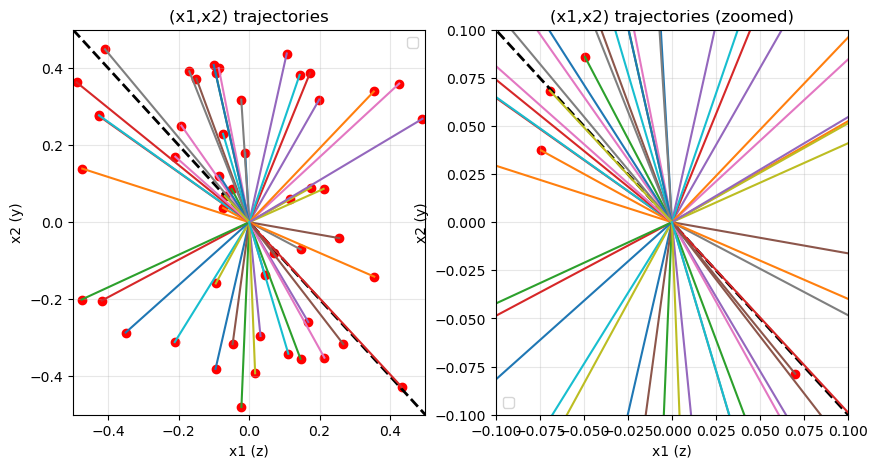

In [2]:
%load_ext autoreload
%autoreload 2

import os, sys
from matplotlib import pyplot as plt
from tqdm import tqdm
import jax, flax
from double_integrator import *


box_width = 0.5

cfg_rom = CfgROM()
cfg_rollout = CfgRollout()
rng = jax.random.PRNGKey(42)

params = flax.core.FrozenDict({}) # place holder for NN parameters
ts = jnp.arange(cfg_rollout.t0, cfg_rollout.t1 + cfg_rollout.dt, cfg_rollout.dt)
x0s = jax.random.uniform(rng, (50, 2), minval=-box_width, maxval=box_width)

integrator = Integrator(
    solver=partial(dfx.diffeqsolve, solver=dfx.Tsit5()),
    ts=ts,
    args_dfx=ArgsDiffrax(cfg_rom=cfg_rom)
)

ret = integrator.apply_batch(x0s)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_xlim(-box_width, box_width)
ax1.set_ylim(-box_width, box_width)
ax2.set_xlim(-0.1, 0.1)
ax2.set_ylim(-0.1, 0.1)
ax1.set_title('(x1,x2) trajectories')
ax2.set_title('(x1,x2) trajectories (zoomed)')

for ax in (ax1, ax2):
    ax.set_xlabel('x1 (z)')
    ax.set_ylabel('x2 (y)')
    ax.grid(True, alpha=0.3)
    ax.legend()

# Zero dynamics line
x1s = jnp.linspace(-box_width, box_width, 100)
x2s = -cfg_rom.kpsi * x1s
ax1.plot(x1s, x2s, 'k--', linewidth=2, label='Zero dynamics line')
ax2.plot(x1s, x2s, 'k--', linewidth=2, label='Zero dynamics line')

for ax in (ax1, ax2):
    for i in range(ret.xs.shape[0]):
        ax.plot(ret.xs[i, :, 0], ret.xs[i, :, 1])
        ax.scatter(ret.xs[i, 0, 0], ret.xs[i, 0, 1], color='red')


plt.show()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 10/10 [00:03<00:00,  2.76it/s]
/tmp/ipykernel_18138/381038884.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


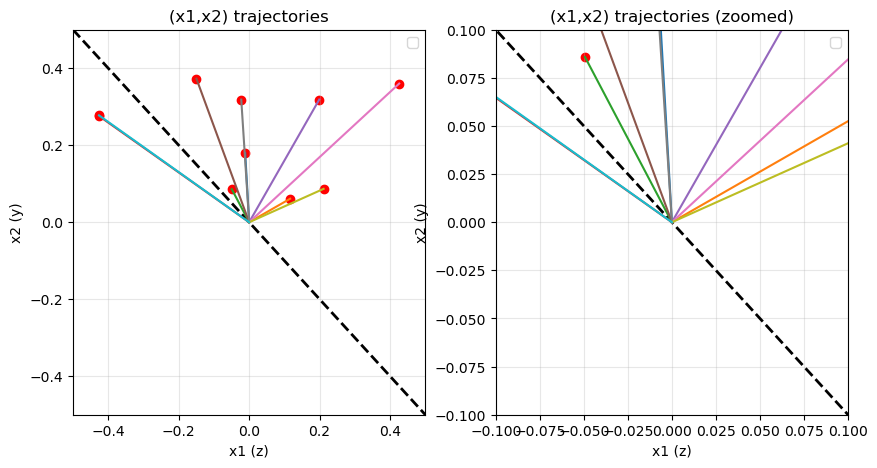

In [3]:
%load_ext autoreload
%autoreload 2

import os, sys
from matplotlib import pyplot as plt
from tqdm import tqdm
import jax, flax
from double_integrator import *


box_width = 0.5

cfg_rom = CfgROM()
cfg_rollout = CfgRollout()
rng = jax.random.PRNGKey(42)

params = flax.core.FrozenDict({}) # place holder for NN parameters
ts = jnp.arange(cfg_rollout.t0, cfg_rollout.t1 + cfg_rollout.dt, cfg_rollout.dt)
x0s = jax.random.uniform(rng, (10, 2), minval=-box_width, maxval=box_width)

integrator = Integrator(
    solver=partial(dfx.diffeqsolve, solver=dfx.Tsit5()),
    ts=ts,
    args_dfx=ArgsDiffrax(cfg_rom=cfg_rom)
)

rets = []
for x0 in tqdm(x0s):
    ret = integrator.apply(x0)
    rets.append(ret)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_xlim(-box_width, box_width)
ax1.set_ylim(-box_width, box_width)
ax2.set_xlim(-0.1, 0.1)
ax2.set_ylim(-0.1, 0.1)
ax1.set_title('(x1,x2) trajectories')
ax2.set_title('(x1,x2) trajectories (zoomed)')

for ax in (ax1, ax2):
    ax.set_xlabel('x1 (z)')
    ax.set_ylabel('x2 (y)')
    ax.grid(True, alpha=0.3)
    ax.legend()

# Zero dynamics line
x1s = jnp.linspace(-box_width, box_width, 100)
x2s = -cfg_rom.kpsi * x1s
ax1.plot(x1s, x2s, 'k--', linewidth=2, label='Zero dynamics line')
ax2.plot(x1s, x2s, 'k--', linewidth=2, label='Zero dynamics line')

for ax in (ax1, ax2):
    for ret in rets:
        ax.plot(ret.xs[:, 0], ret.xs[:, 1])
        ax.scatter(ret.xs[0, 0], ret.xs[0, 1], color='red')


plt.show()
